# Wine Review Sentiment Analysis Model 

This notebook demonstrates the process of training a sentiment analysis model to predict whether a wine review is positive or negative. The goal of this project is to focus on positive wine reviews, as we are more interested in understanding customer satisfaction. This insight will help us identify which wines customers are likely to enjoy, make informed recommendations, and prioritize those with the most positive reviews for increased advertising efforts.

The skeleton of the notebook:
1. Building a model to classify wine reviews based on sentiment.
2. Using SMOTE to balance the dataset to ensure the model is fair and robust.
3. Using Joblib to save the trained model and preprocessing tools for integration into a Streamlit app.


# Import libraries:

In [1]:
import os
import gdown
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns



# info

In [2]:
# Define the folder path at the root level
repo_root = os.path.dirname(os.getcwd())  # Moves one level up from `wine_model_notebooks`
data_folder = os.path.join(repo_root, 'DataSets')

# Ensure the DataSets folder exists at the root level
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Define file download details
file_id = '1qd2rIjiqfx9dZ1q_aufpkwfZsl7u3DQb'
url = f'https://drive.google.com/uc?id={file_id}'
output = os.path.join(data_folder, 'winemag-data-130k-v2.csv')

# Download and save file
gdown.download(url, output, quiet=False)

# Load the file
df = pd.read_csv(output, encoding='ISO-8859-1')
print(df.head())


Downloading...
From: https://drive.google.com/uc?id=1qd2rIjiqfx9dZ1q_aufpkwfZsl7u3DQb
To: /Users/yanellyhernandez/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Learning Fuze/Streamlit_Projects/DataSets/winemag-data-130k-v2.csv
100%|██████████| 52.9M/52.9M [00:09<00:00, 5.33MB/s]


   Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                       VulkÃ  Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0              

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [4]:
df['description']

0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 129971, dtype: object

# Tokenize the description ft

In [5]:
# Download 'punkt_tab':
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yanellyhernandez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
# Tokenize the description:
df['description'] = df['description'].apply(nltk.word_tokenize)
df['description']


0         [Aromas, include, tropical, fruit, ,, broom, ,...
1         [This, is, ripe, and, fruity, ,, a, wine, that...
2         [Tart, and, snappy, ,, the, flavors, of, lime,...
3         [Pineapple, rind, ,, lemon, pith, and, orange,...
4         [Much, like, the, regular, bottling, from, 201...
                                ...                        
129966    [Notes, of, honeysuckle, and, cantaloupe, swee...
129967    [Citation, is, given, as, much, as, a, decade,...
129968    [Well-drained, gravel, soil, gives, this, wine...
129969    [A, dry, style, of, Pinot, Gris, ,, this, is, ...
129970    [Big, ,, rich, and, off-dry, ,, this, is, powe...
Name: description, Length: 129971, dtype: object

# Remove stop words

In [7]:
# Download stop words:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yanellyhernandez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Checking the length of the stop words:
len(stopwords.words("english"))

179

In [9]:
# a list if the stopwords:
stop_words = stopwords.words("english")
stop_words 

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
# Including a , and . in the stop words y appending it to the list:
stop_words.append(',')
stop_words.append('.')

In [11]:
print("wine" in stop_words) # Checking if wine is in stop words

False


In [12]:
# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply stopwords removal to the description column
df['description_cleaned'] = df['description'].apply(remove_stopwords)

# Display the cleaned description
df[['description', 'description_cleaned']].head()

,description,description_cleaned
0,"[Aromas, include, tropical, fruit, ,, broom, ,...","[Aromas, include, tropical, fruit, broom, brim..."
1,"[This, is, ripe, and, fruity, ,, a, wine, that...","[ripe, fruity, wine, smooth, still, structured..."
2,"[Tart, and, snappy, ,, the, flavors, of, lime,...","[Tart, snappy, flavors, lime, flesh, rind, dom..."
3,"[Pineapple, rind, ,, lemon, pith, and, orange,...","[Pineapple, rind, lemon, pith, orange, blossom..."
4,"[Much, like, the, regular, bottling, from, 201...","[Much, like, regular, bottling, 2012, comes, a..."


In [13]:
# checking the length of the stop words to see if they included , and . 
len(stop_words) 

181

In [14]:
print("wine" in stop_words)

False


Removing stopwords helps improve the model's ability to classify reviews as positive or negative by eliminating common, less meaningful words (e.g., 'the', 'and', 'is') that do not contribute to the sentiment of the review. These words often occur frequently but don't provide valuable information for distinguishing sentiment.

# Lemmatize the tokens

In [15]:
# Download the wordnet:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yanellyhernandez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# Initialize the Word Net Lemmatizer:
wnl = WordNetLemmatizer()

In [17]:
# Function to lemmatize the tokens:
def lem_token(tokens):
    return [wnl.lemmatize(word) for word in tokens]

In [18]:
# Apply stemming to the cleaned description
df['Cleaned_Lemma_Description'] = df['description_cleaned'].apply(lem_token)

# Display the cleaned and stemmed description
df[['description', 'Cleaned_Lemma_Description']].head()

,description,Cleaned_Lemma_Description
0,"[Aromas, include, tropical, fruit, ,, broom, ,...","[Aromas, include, tropical, fruit, broom, brim..."
1,"[This, is, ripe, and, fruity, ,, a, wine, that...","[ripe, fruity, wine, smooth, still, structured..."
2,"[Tart, and, snappy, ,, the, flavors, of, lime,...","[Tart, snappy, flavor, lime, flesh, rind, domi..."
3,"[Pineapple, rind, ,, lemon, pith, and, orange,...","[Pineapple, rind, lemon, pith, orange, blossom..."
4,"[Much, like, the, regular, bottling, from, 201...","[Much, like, regular, bottling, 2012, come, ac..."


Lemmatizing the words reduces variations of the same word to its base or root form (e.g., 'running' becomes 'run'). This helps standardize the words, making it easier for the model to identify the sentiment without being distracted by different word forms. I chose lemmatization over stemming because lemmatization provides greater accuracy for sentiment analysis models. Unlike stemming, which simply removes word endings, lemmatization considers the context of a word and reduces it to its meaningful base or dictionary form. This makes lemmatization more appropriate for sentiment analysis, as understanding the precise meaning of words in context is crucial for accurately determining sentiment.

# pickle for wordcloud in py file

In [19]:
# Saving the dataframe:
joblib.dump(df, 'Cleaned_Wine_df.plk')

['Cleaned_Wine_df.plk']

# Sentamental Analysis

In [20]:
# Saving the Sentimental analysis with using polarity scores:
df['Sentiment'] = df['description'].apply(lambda x: 1 if TextBlob(str(x)).sentiment.polarity > 0
                                                        else 0)

In [21]:
df['Sentiment']

0         1
1         1
2         1
3         1
4         1
         ..
129966    1
129967    1
129968    1
129969    1
129970    1
Name: Sentiment, Length: 129971, dtype: int64

# model

In [22]:
X = df['Cleaned_Lemma_Description'].apply(lambda x: ' '.join(x))  # Join lists back to strings
y = df['Sentiment'] # Assigning y to Sentiment

# Splitting into train and test:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [23]:
x_train

118969    Aromatically dazzling wine show complex note s...
3136      Earthy deep true Uco Valley root ; good fairly...
77944     Made Moscato Giallo grape harvested late thoug...
64964     Fresh informal lean easygoing red offer aroma ...
5082      Snappy dry red-fruit citrus aroma good opening...
                                ...                        
128106    Fresh white peach green melon flavor shine zes...
103694    Aromas fragrant spring blossom orchard fruit h...
860       Fresh cracked peppercorn dense black purple fr...
15795     blend 50 % Cabernet Sauvignon 25 % Merlot 25 %...
121958    Maestro open fruit balsamic aroma red currant ...
Name: Cleaned_Lemma_Description, Length: 97478, dtype: object

In [24]:
# Initialize tfidf
tfidf = TfidfVectorizer()
# fit_transform on x_train:
x_train_tfidf = tfidf.fit_transform(x_train)
# transform on x_test:
x_test_tfidf = tfidf.transform(x_test)

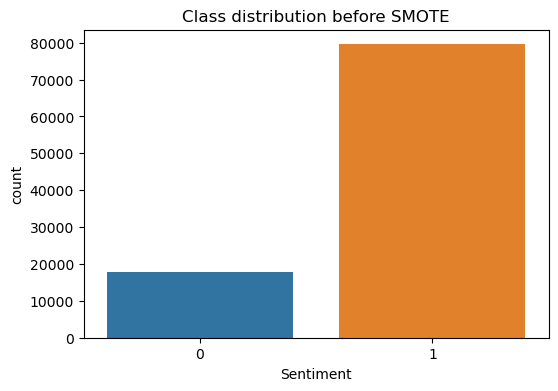

In [25]:
# checking if the dataset is balanced or not:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class distribution before SMOTE")
plt.show()

Here we can see that there is class is not balancde hence I will balance the class using SMOTE.

In [26]:
# Define if you want to balance your dataset
BALANCE_TARGET = True
SMOTE_BALANCE = True

# Balance the training data based on conditions
if BALANCE_TARGET:
    if SMOTE_BALANCE:
        # Apply SMOTE to balance the target variable
        smote = SMOTE(random_state=42)
        x_train_balanced, y_train_balanced = smote.fit_resample(x_train_tfidf, y_train)
    else:
        # Undersample the majority class if not using SMOTE
        undersampler = RandomUnderSampler(random_state=42)
        x_train_balanced, y_train_balanced = undersampler.fit_resample(x_train_tfidf, y_train)



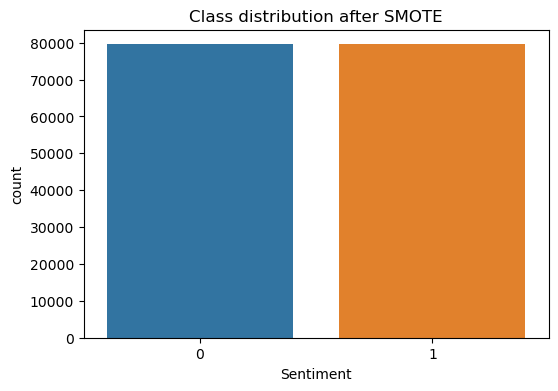

In [27]:
# Visualize the balance
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_balanced)
plt.title("Class distribution after SMOTE")
plt.show()

The following visualizations show the class distribution in the training set before and after applying SMOTE (Synthetic Minority Over-sampling Technique) to balance the target variable. This step is crucial for ensuring that the model is not biased toward the majority class (positive reviews). 

In [28]:
# Save the tfidf to use for streamlit:
joblib.dump(tfidf, 'tfidf_Vectorizer_Wine.pkl')

['tfidf_Vectorizer_Wine.pkl']

In [29]:
# Use RandomForestClassifier:
model = RandomForestClassifier(random_state=1)
# Fit the model:
model.fit(x_train_balanced, y_train_balanced)
# Predict on x_test_tfidf:
y_pred = model.predict(x_test_tfidf)


In [30]:
# Evaluate the model's accuracy and claas_report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(accuracy)
print(class_report)


0.8742498384267381
              precision    recall  f1-score   support

           0       0.75      0.46      0.57      5902
           1       0.89      0.97      0.93     26591

    accuracy                           0.87     32493
   macro avg       0.82      0.71      0.75     32493
weighted avg       0.86      0.87      0.86     32493



Based on the classification report, we can see that the model performs well in identifying positive reviews, which aligns with our primary goal of building a recommendation system for marketing purposes. Positive reviews are strong (high precision, recall, and F1-score), making the model suitable for recommending products to customers who are likely to be satisfied. If the overall objective were to detect negative reviews for customer support or issue resolution, I would focus on improving the performance for class 0 (negative reviews). However, for this project, the primary focus is on positive reviews, and thus the current model is well-suited for our marketing goals.

In [34]:
# Save model:
joblib.dump(model, 'Wine_model.pkl')

['Wine_model.pkl']

In [32]:
model

RandomForestClassifier(random_state=1)

In [33]:
# Save eval metrics:
joblib.dump((accuracy,class_report), 'Evaluation_Metrics_Wine.pkl')

['Evaluation_Metrics_Wine.pkl']

Saving both the tfidf and eval metrics for streamlit